In [2]:
import warnings

import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.units import UnitsWarning
from tqdm import tqdm

from plato.stars import classify_stars, quality_cuts
from plato.utils import accumulate_from_sources, get_abspath

A new version of galpy (1.10.2) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [ ]:
# process targets

# load targets
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UnitsWarning)
    targets = Table.read(get_abspath() + "data/WIP/TESS_targets.fits").to_pandas()
# make quality cuts
categorized_targets = quality_cuts(targets, max_error=0.2)

# add classification
categorized_targets = classify_stars(
    categorized_targets,
    include_galactic_quantities=True,
    include_probabilities=True,
)

# merge back in with targets
targets = targets.merge(
    categorized_targets[
        [col for col in categorized_targets.columns if col not in targets.columns]
        + ["dr2_source_id"]
    ],
    on="dr2_source_id",
    how="left",
)

# rename columns
targets.rename(
    columns={
        "SOURCE_ID": "gaiaID_DR3",
        "dr2_source_id": "gaiaID_DR2",
    },
    inplace=True,
)
for col in targets.columns:
    if col.endswith("_error"):
        targets.rename(columns={col: f"e_{col[:-6]}"}, inplace=True)

Removed 1317/5024 stars based on quality cuts (35.5%).


Retrieving Kinematic Parameter: 100%|██████████| 3707/3707 [00:00<00:00, 3768.22it/s]


In [3]:
# add xgboost metallicities from Andrae2023
total_rows = 174922161
chunksize = int(1e7)
xgboost_data = []

# load in chuncks
for chunk in tqdm(
    pd.read_csv(
        get_abspath() + "data/external/xgboost.csv",
        chunksize=chunksize,
        compression="gzip",
        usecols=["source_id", "mh_xgboost", "logg_xgboost"],
    ),
    total=total_rows // chunksize + 1,
    desc="Processing chunks: ",
):
    # Select only the targets
    filtered_chunk = chunk[chunk["source_id"].isin(targets["gaiaID_DR3"])]
    xgboost_data.append(filtered_chunk)

xgboost_data = pd.concat(xgboost_data).rename(columns={"source_id": "gaiaID_DR3"})
xgboost_data = xgboost_data.assign(
    mh_xgboost_lower=np.nan,
    mh_xgboost_upper=np.nan,
    logg_xgboost_lower=np.nan,
    logg_xgboost_upper=np.nan,
)
targets = targets.merge(xgboost_data, on="gaiaID_DR3", how="left")

Processing chunks:   0%|          | 0/18 [00:00<?, ?it/s]

Processing chunks: 100%|██████████| 18/18 [01:38<00:00,  5.47s/it]


In [4]:
# add metallcities and logg columns from GSPSPEC or Andrae2023, depending on which is available
# and quality cuts (quality cuts are based on the first 13 flags of the flags_gspspec columns, based
# on the astrophysical_parameters documentation/Recio-Blanco2023)
gspspec_quality_mask = (
    targets["flags_gspspec"]
    .astype(str)
    .apply(lambda x: all([i == "0" for i in x[:13]]) if isinstance(x, str) else False)
)
# add [Fe/H] metallcity column, filled in following priority: gspspec,
# xgboost (use next possible source if previous is NaN)
targets = accumulate_from_sources(
    targets,
    "[Fe/H]",
    source_columns=["mh_gspspec", "mh_xgboost"],
    additional_masks={"mh_gspspec": gspspec_quality_mask},
    drop_sources=True,
)

# add logg column, filled in following priority: gspspec, gspphot, xgboost
targets = accumulate_from_sources(
    targets,
    "logg",
    source_columns=["logg_gspspec", "logg_xgboost"],
    additional_masks={"logg_gspspec": gspspec_quality_mask},
    drop_sources=True,
)
targets.drop(columns=["flags_gspspec"], inplace=True)


# rename alphafe_gspspec column (and errors) to [alpha/Fe]
targets.rename(
    columns={
        "alphafe_gspspec": "[alpha/Fe]",
        "alphafe_gspspec_lower": "e_[alpha/Fe]_lower",
        "alphafe_gspspec_upper": "e_[alpha/Fe]_upper",
    },
    inplace=True,
)

In [ ]:
# add metallicities, alpha and log g from high-res spectroscopic surveys

## Apogee
apogee = Table.read(get_abspath() + "data/external/apogee.fits", hdu=1)
# get relevant columns
apogee = apogee[
    [
        "GAIAEDR3_SOURCE_ID",
        "FE_H",
        "FE_H_ERR",
        "ALPHA_M",
        "ALPHA_M_ERR",
        "LOGG",
        "LOGG_ERR",
        "ASPCAPFLAGS",
    ]
]
apogee_df = apogee.to_pandas()
# qulaity cuts (drop entries where ALPHA_M or M_H is flagged)
apogee_df = apogee_df[
    ~apogee_df["ASPCAPFLAGS"].astype(str).str.contains("ALPHA_M|M_H|STAR_WARN")
].drop(columns="ASPCAPFLAGS")

apogee_df = apogee_df.rename(
    columns={
        "GAIAEDR3_SOURCE_ID": "gaiaID_DR3",
        "FE_H": "[Fe/H]_apogee",
        "FE_H_ERR": "e_[Fe/H]_apogee",
        "ALPHA_M": "[alpha/M]_apogee",
        "ALPHA_M_ERR": "e_[alpha/M]_apogee",
        "LOGG": "logg_apogee",
        "LOGG_ERR": "e_logg_apogee",
    }
)
# merge into targets
targets = pd.merge(
    targets,
    apogee_df.drop_duplicates(subset="gaiaID_DR3", keep="first"),
    on="gaiaID_DR3",
    how="left",
)

## GALAH
with warnings.catch_warnings():
    # silence warning for log(cm.s**-2) units
    warnings.simplefilter("ignore", UnitsWarning)
    galah = Table.read(get_abspath() + "data/external/galah.fits")
# quality cuts
galah = galah[galah["flag_sp"] == 0]
galah = galah[galah["flag_fe_h"] == 0]
galah = galah[galah["flag_alpha_fe"] == 0]
# get relevant columns
galah = galah[
    [
        "dr3_source_id",
        "fe_h",
        "e_fe_h",
        "alpha_fe",
        "e_alpha_fe",
        "logg",
        "e_logg",
    ]
]
galah_df = galah.to_pandas()
galah_df = galah_df.rename(
    columns={
        "dr3_source_id": "gaiaID_DR3",
        "fe_h": "[Fe/H]_galah",
        "e_fe_h": "e_[Fe/H]_galah",
        "alpha_fe": "[alpha/Fe]_galah",
        "e_alpha_fe": "e_[alpha/Fe]_galah",
        "logg": "logg_galah",
        "e_logg": "e_logg_galah",
    }
)
# merge into targets
targets = pd.merge(
    targets,
    galah_df.drop_duplicates(subset="gaiaID_DR3", keep="first"),
    on="gaiaID_DR3",
    how="left",
)

In [ ]:
# save
targets.to_csv(get_abspath() + "data/WIP/TESS_targets.csv", index=False)

In [3]:
targets = pd.read_csv(get_abspath() + "data/WIP/TESS_targets.csv")

In [4]:
toms = pd.read_parquet(get_abspath() + "data/WIP/tess_halo_gaia.parquet")

In [10]:
halo = targets[targets["gaiaID_DR3"].isin(toms["source_id"])]

In [13]:
toi = pd.read_csv(get_abspath() + "data/WIP/TESS_TOI.csv", comment="#")

In [11]:
halo

,gaiaID_DR3,parallax,e_parallax,ra,e_ra,dec,e_dec,pmra,e_pmra,pmdec,...,[alpha/M]_apogee,e_[alpha/M]_apogee,logg_apogee,e_logg_apogee,[Fe/H]_galah,e_[Fe/H]_galah,[alpha/Fe]_galah,e_[alpha/Fe]_galah,logg_galah,e_logg_galah
154,242281445931296000,-0.044405,0.174458,49.858978,0.124030,44.746406,0.108521,-1.725815,0.206538,-2.552914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,331112742681453440,3.402920,0.042186,33.348982,0.025906,36.521992,0.032607,180.829487,0.037773,-20.803297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,1853079724527137664,-0.207814,0.297121,316.939744,0.151749,31.780953,0.237907,0.817740,0.200041,3.914709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1313,1898455332441340416,-0.114957,0.424716,333.131943,0.201392,31.364659,0.336564,4.715003,0.263491,-8.298188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1677,2123995644386597888,2.302456,0.009420,273.788888,0.009066,50.862729,0.009132,-61.201523,0.012057,-72.152229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2119,2560480320135497216,2.911060,0.021880,26.308572,0.018673,3.513637,0.016671,228.028627,0.024301,-9.582763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,2797852476706070272,2.688373,0.018656,4.219136,0.014504,20.432765,0.011603,17.868185,0.020466,-142.532765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3307,4926216270336265088,1.038415,0.014094,8.482000,0.008173,-50.729439,0.009758,14.817633,0.009399,-34.163230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3460,5244482521030780416,-0.155539,0.301005,154.273613,0.292813,-68.883737,0.259709,-22.970959,0.387534,0.899629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3685,5338235158805452544,0.064901,0.031578,163.675472,0.025160,-60.347786,0.027759,-6.359670,0.033576,3.436884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
targets

,gaiaID_DR3,parallax,e_parallax,ra,e_ra,dec,e_dec,pmra,e_pmra,pmdec,...,[alpha/M]_apogee,e_[alpha/M]_apogee,logg_apogee,e_logg_apogee,[Fe/H]_galah,e_[Fe/H]_galah,[alpha/Fe]_galah,e_[alpha/Fe]_galah,logg_galah,e_logg_galah
0,16870631694208,2.101317,0.017279,45.112778,0.016310,0.380840,0.011938,-0.969421,0.017739,-12.268805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5642251292706560,5.630601,0.111837,41.036555,0.104020,3.910230,0.111842,35.191806,0.133079,-13.430419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5900705244680192,11.040556,0.018207,41.380427,0.015744,5.150722,0.013853,169.712099,0.022668,-76.791666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6612604664008320,1.576702,0.014388,41.506680,0.012912,6.461722,0.010550,4.107720,0.017471,-12.317701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8727137322879488,3.144343,0.017588,44.245076,0.014456,7.859330,0.016032,-11.105799,0.019388,-10.701761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5019,6909261529129729536,1.994737,0.023136,317.473504,0.020014,-7.415148,0.013485,-19.027873,0.024768,-22.851121,...,-0.003172,0.007007,4.253926,0.020638,NaN,NaN,NaN,NaN,NaN,NaN
5020,6909776680392269824,1.136538,0.023010,313.272306,0.018467,-7.474877,0.009294,17.533136,0.025580,-4.215833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5021,6911563253643561216,1.071894,0.018541,319.780293,0.014655,-4.741358,0.012921,1.238453,0.018740,-6.478957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5022,6911770850887194112,1.043669,0.020047,319.530767,0.018234,-4.447345,0.013566,9.998036,0.024612,-18.928960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([  1.,   0.,   0.,   0.,   0.,   2.,   2.,   0.,   3.,   4.,   3.,
         12.,  12.,  22.,  70.,  65.,  73., 110., 137., 132., 159., 186.,
        157., 136., 130.,  84.,  64.,  49.,  44.,  24.,  28.,  21.,  15.,
         11.,   8.,   8.,   5.,  21.,   6.,   5.,   7.,   8.,   4.,  17.,
          5.,   2.,   4.,   2.,   1.,   1.,   0.,   0.,   1.,   1.,   1.,
          1.]),
 array([-0.55      , -0.51928571, -0.48857143, -0.45785714, -0.42714286,
        -0.39642857, -0.36571429, -0.335     , -0.30428571, -0.27357143,
        -0.24285714, -0.21214286, -0.18142857, -0.15071429, -0.12      ,
        -0.08928571, -0.05857143, -0.02785714,  0.00285714,  0.03357143,
         0.06428571,  0.095     ,  0.12571429,  0.15642857,  0.18714286,
         0.21785714,  0.24857143,  0.27928571,  0.31      ,  0.34071429,
         0.37142857,  0.40214286,  0.43285714,  0.46357143,  0.49428571,
         0.525     ,  0.55571429,  0.58642857,  0.61714286,  0.64785714,
         0.67857143,  0.709285

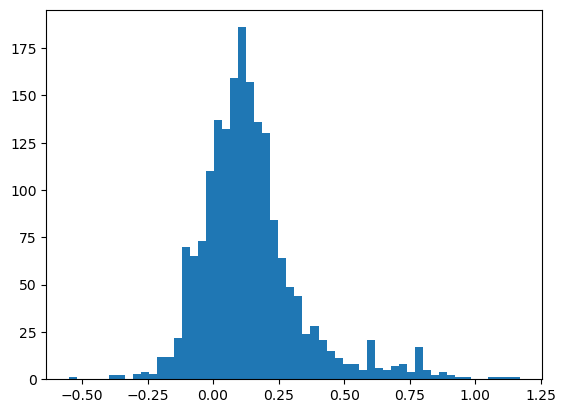

In [10]:
import matplotlib.pyplot as plt

d = 1 / targets["parallax"]
d = d[d > 0]

plt.hist(targets["[alpha/Fe]"], bins="fd")

<Axes: >

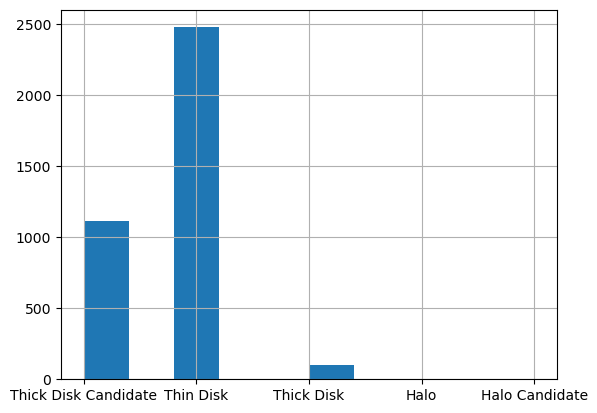

In [15]:
targets["Population"].hist()

In [17]:
(targets["Population"] == "Halo").sum()

4